### Imports

In [9]:
%matplotlib inline
import warnings
warnings.filterwarnings('ignore')

# Core scientific stack
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec

# File handling
import os
from os.path import join as pathjoin
from glob import glob
from pathlib import Path

# Neuroimaging
import nibabel as nib
from nilearn import datasets, plotting, image
from nilearn.decoding import Decoder
from nilearn.image import mean_img, get_data
from nilearn.input_data import NiftiMasker
from nilearn.plotting import plot_matrix, show

# SciPy
import scipy
from scipy import stats, signal, ndimage
from scipy.ndimage import gaussian_filter
from scipy.stats import pearsonr, norm, zscore, sem
from scipy.signal import savgol_filter
from scipy.optimize import curve_fit

# Scikit-learn
from sklearn import svm
from sklearn.svm import LinearSVC, SVC
from sklearn.multiclass import OneVsOneClassifier, OneVsRestClassifier
from sklearn.linear_model import LogisticRegression, LinearRegression
from sklearn.feature_selection import SelectKBest, f_classif
from sklearn.model_selection import (
    StratifiedKFold, LeaveOneGroupOut, LeavePGroupsOut,
    train_test_split, cross_val_score, cross_validate,
    RepeatedKFold, GroupKFold
)
from sklearn.pipeline import make_pipeline, Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import confusion_matrix

# Miscellaneous
from itertools import permutations, combinations, groupby
from math import exp, sqrt

# Plot style
plt.style.use("https://raw.githubusercontent.com/NeuromatchAcademy/course-content/master/nma.mplstyle")

%pylab


Using matplotlib backend: MacOSX
Populating the interactive namespace from numpy and matplotlib


### Figure 2A

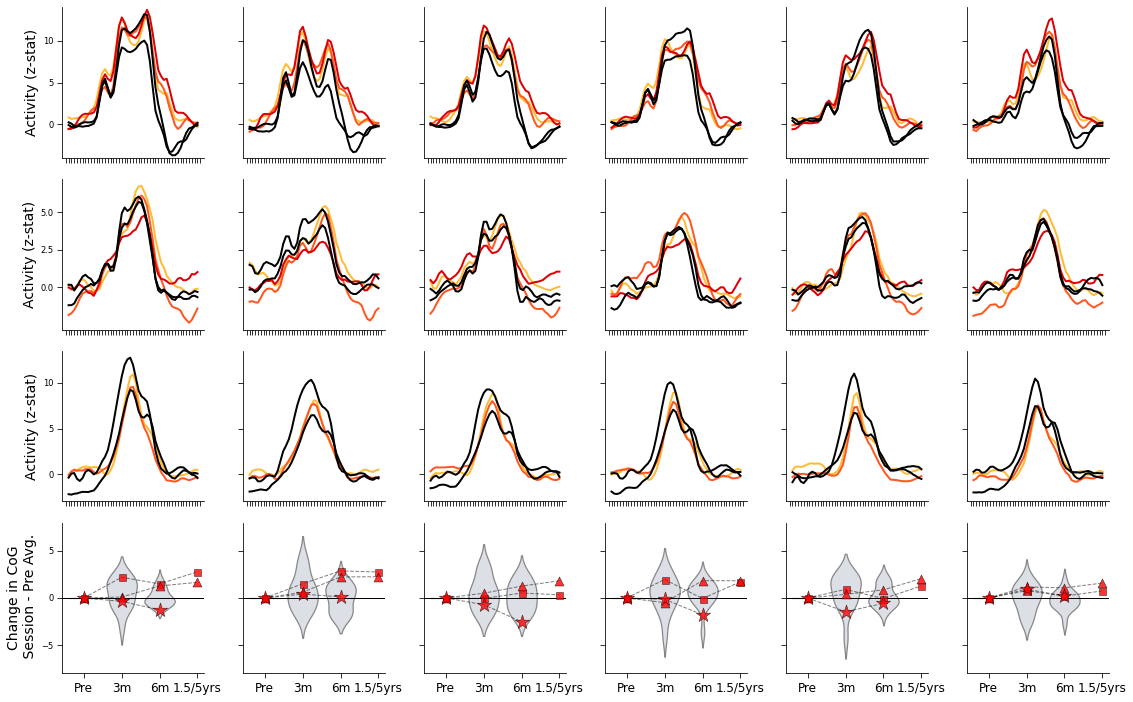

In [6]:
%matplotlib inline
# load data
df = pd.read_csv('./data/Figure2A_data.csv')
cog = pd.read_csv('./data/Figure2A_COG_data.csv')

#dropping co05 post1 session, due to no data collected
cog = cog[~((cog['subj'] == 'sub-co05') & (cog['session'] == 'post1'))]

# Define a function to map the values in the 'subj' column to the corresponding group numbers
def map_subj_to_group(subj):
    if subj.startswith('sub-co'):
        return 0
    elif subj == 'sub-aa02':
        return 1
    elif subj == 'sub-aa06':
        return 2
    elif subj == 'sub-aa03':
        return 3
    else:
        return 4  # or raise an error if there are other values in the 'subj' column

# Apply the mapping function to the 'subj' column and assign the result to the 'group' column
df['group'] = df['subj'].apply(map_subj_to_group)

# define session, cope, and hemi values
sessions = ['pre1', 'pre2', 'pre3','pre4','post1', 'post2','post3']
copes = [1,2,3,4,5,6,7,8,9,10,14,15]
hemis = ['lh', 'rh']
groups = [0,1,2,3]
# create a dictionary of dataframes for each group, session, cope, and hemi combination
dataframes = {}
for session in sessions:
    for cope in copes:
        for hemi in hemis:
            for group in groups:
                dataframe = df.loc[(df.group == group) & (df.session == session) & (df.cope == cope) & (df.hemi == hemi)]
                dataframe_name = 'group' + str(group) + '_' + session + '_' + str(hemi) + '_' + str(cope)
                dataframes[dataframe_name] = dataframe

# BUILD A DICTIONARY TO USE FOR PLOTTING FOR THE CONTROLS, AMP01 AND AMP02
copes = [1,2,3,4,5,6,7,8,9,10,14,15]
hemis = ['lh','rh']

ctrls_dfs = {}
for cop in copes:
    for hem in hemis:
        ctrls_df = cog.loc[(cog.group == 0) & (cog.cope == cop) & (cog.hemi == hem)]
        df_name = 'ctrls_' + str(hem) + '_' + str(cop)
        ctrls_dfs[df_name] = ctrls_df

amp01_dfs = {}
for cop in copes:
    for hem in hemis:
        amp01_df = cog.loc[(cog.subj == 'sub-aa02') & (cog.cope == cop)& (cog.hemi == hem)]
        df_name = 'amp01_' + str(hem) + '_' + str(cop)
        amp01_dfs[df_name] = amp01_df

amp02_dfs = {}
for cop in copes:
    for hem in hemis:
        amp02_df = cog.loc[(cog.subj == 'sub-aa06') & (cog.cope == cop)& (cog.hemi == hem)]
        df_name = 'amp02_' + str(hem) + '_' + str(cop)
        amp02_dfs[df_name] = amp02_df       
    
amp03_dfs = {}
for cop in copes:
    for hem in hemis:
        amp03_df = cog.loc[(cog.subj == 'sub-aa03') & (cog.cope == cop)& (cog.hemi == hem)]
        df_name = 'amp03_' + str(hem) + '_' + str(cop)
        amp03_dfs[df_name] = amp03_df 

# define plotting parameters
fig, axes = plt.subplots(4, 6, figsize=(16, 10), sharey='row', sharex='row')
#fig.subplots_adjust(hspace=13, wspace=0.2)
fig.subplots_adjust(hspace=0.5, wspace=0.3)

plt.style.use("https://raw.githubusercontent.com/NeuromatchAcademy/course-content/master/nma.mplstyle")

pre1_color = ['black']
pre2_color = ['black']
post1_color = ['#FFBB33']
post2_color = ['#FF571F']
post3_color = ['#DD0007']
colors = ['#DBDFE6','#DBDFE6','#DBDFE6']
ctrl_color = ['#767382','#767382','#767382']
amp01_color = ['red','red']
amp02_color = ['red','red']

# SMOOTHING APPROACHES
def line_plot(axis, dataframe, sess_color,ls,smoothing=None):
    sns.set_palette(sess_color)

    if smoothing is None:
        sns.lineplot(
            ax=axis,
            x='band',
            y='fslmeants',
            hue='subj',
            linewidth=2,
         #   palette=colors_for_cope,
            data=dataframe,
            legend=None, linestyle=ls
        )
    elif smoothing == 'rolling_mean':
        sns.lineplot(
            ax=axis,
            x='band',
            y=dataframe['fslmeants'].rolling(3, center=True).mean(),
            hue='subj',
            linewidth=2,
            color=sess_color,
         #   palette=colors_for_cope,
            data=dataframe,
            legend=None, linestyle=ls
        )
    elif smoothing == 'rolling_median':
        sns.lineplot(
            ax=axis,
            x='band',
            y=dataframe['fslmeants'].rolling(5, center=True).median(),
            hue='subj',
            linewidth=2,
         #   palette=colors_for_cope,
            data=dataframe,
            legend=None, linestyle=ls
        )
    elif smoothing == 'savitzky_golay':
        y = dataframe['fslmeants'].values
        y_smoothed = savgol_filter(y, window_length=5, polyorder=2)
        sns.lineplot(
            ax=axis,
            x='band',
            y=y_smoothed,
            hue='subj',
            linewidth=2,
           # palette=colors_for_cope,
            data=dataframe,
            legend=None, linestyle=ls
        )
    elif smoothing == 'gaussian':
        y = dataframe['fslmeants'].values
        y_smoothed = gaussian_filter1d(y, sigma=1)
        sns.lineplot(
            ax=axis,
            x='band',
            y=y_smoothed,
            hue='subj',
            linewidth=2,
         #   palette=colors_for_cope,
            data=dataframe,
            legend=None, linestyle=ls
        )


line_plot(axes[1,0],dataframes['group1_post1_lh_15'],post1_color,'-',smoothing='rolling_mean')
line_plot(axes[1,0],dataframes['group1_post2_lh_15'],post2_color,'-',smoothing='rolling_mean')
line_plot(axes[1,0],dataframes['group1_post3_lh_15'],post3_color,'-',smoothing='rolling_mean')
line_plot(axes[1,0],dataframes['group1_pre1_lh_15'],pre1_color,'-',smoothing='rolling_mean')
line_plot(axes[1,0],dataframes['group1_pre2_lh_15'],pre2_color,'-',smoothing='rolling_mean')

line_plot(axes[1,1],dataframes['group1_post1_lh_6'],post1_color,'-',smoothing='rolling_mean')
line_plot(axes[1,1],dataframes['group1_post2_lh_6'],post2_color,'-',smoothing='rolling_mean')
line_plot(axes[1,1],dataframes['group1_post3_lh_6'],post3_color,'-',smoothing='rolling_mean')
line_plot(axes[1,1],dataframes['group1_pre1_lh_6'],pre1_color,'-',smoothing='rolling_mean')
line_plot(axes[1,1],dataframes['group1_pre2_lh_6'],pre2_color,'-',smoothing='rolling_mean')

line_plot(axes[1,2],dataframes['group1_post1_lh_7'],post1_color,'-',smoothing='rolling_mean')
line_plot(axes[1,2],dataframes['group1_post2_lh_7'],post2_color,'-',smoothing='rolling_mean')
line_plot(axes[1,2],dataframes['group1_post3_lh_7'],post3_color,'-',smoothing='rolling_mean')
line_plot(axes[1,2],dataframes['group1_pre1_lh_7'],pre1_color,'-',smoothing='rolling_mean')
line_plot(axes[1,2],dataframes['group1_pre2_lh_7'],pre2_color,'-',smoothing='rolling_mean')

line_plot(axes[1,3],dataframes['group1_post1_lh_8'],post1_color,'-',smoothing='rolling_mean')
line_plot(axes[1,3],dataframes['group1_post2_lh_8'],post2_color,'-',smoothing='rolling_mean')
line_plot(axes[1,3],dataframes['group1_post3_lh_8'],post3_color,'-',smoothing='rolling_mean')
line_plot(axes[1,3],dataframes['group1_pre1_lh_8'],pre1_color,'-',smoothing='rolling_mean')
line_plot(axes[1,3],dataframes['group1_pre2_lh_8'],pre2_color,'-',smoothing='rolling_mean')

line_plot(axes[1,4],dataframes['group1_post1_lh_9'],post1_color,'-',smoothing='rolling_mean')
line_plot(axes[1,4],dataframes['group1_post2_lh_9'],post2_color,'-',smoothing='rolling_mean')
line_plot(axes[1,4],dataframes['group1_post3_lh_9'],post3_color,'-',smoothing='rolling_mean')
line_plot(axes[1,4],dataframes['group1_pre1_lh_9'],pre1_color,'-',smoothing='rolling_mean')
line_plot(axes[1,4],dataframes['group1_pre2_lh_9'],pre2_color,'-',smoothing='rolling_mean')

line_plot(axes[1,5],dataframes['group1_post1_lh_10'],post1_color,'-',smoothing='rolling_mean')
line_plot(axes[1,5],dataframes['group1_post2_lh_10'],post2_color,'-',smoothing='rolling_mean')
line_plot(axes[1,5],dataframes['group1_post3_lh_10'],post3_color,'-',smoothing='rolling_mean')
line_plot(axes[1,5],dataframes['group1_pre1_lh_10'],pre1_color,'-',smoothing='rolling_mean')
line_plot(axes[1,5],dataframes['group1_pre2_lh_10'],pre2_color,'-',smoothing='rolling_mean')

line_plot(axes[0,0],dataframes['group2_post1_rh_14'],post1_color,'-',smoothing='rolling_mean')
line_plot(axes[0,0],dataframes['group2_post2_rh_14'],post2_color,'-',smoothing='rolling_mean')
line_plot(axes[0,0],dataframes['group2_post3_rh_14'],post3_color,'-',smoothing='rolling_mean')
line_plot(axes[0,0],dataframes['group2_pre1_rh_14'],pre1_color,'-',smoothing='rolling_mean')
line_plot(axes[0,0],dataframes['group2_pre2_rh_14'],pre2_color,'-',smoothing='rolling_mean')

line_plot(axes[0,1],dataframes['group2_post1_rh_1'],post1_color,'-',smoothing='rolling_mean')
line_plot(axes[0,1],dataframes['group2_post2_rh_1'],post2_color,'-',smoothing='rolling_mean')
line_plot(axes[0,1],dataframes['group2_post3_rh_1'],post3_color,'-',smoothing='rolling_mean')
line_plot(axes[0,1],dataframes['group2_pre1_rh_1'],pre1_color,'-',smoothing='rolling_mean')
line_plot(axes[0,1],dataframes['group2_pre2_rh_1'],pre2_color,'-',smoothing='rolling_mean')

line_plot(axes[0,2],dataframes['group2_post1_rh_2'],post1_color,'-',smoothing='rolling_mean')
line_plot(axes[0,2],dataframes['group2_post2_rh_2'],post2_color,'-',smoothing='rolling_mean')
line_plot(axes[0,2],dataframes['group2_post3_rh_2'],post3_color,'-',smoothing='rolling_mean')
line_plot(axes[0,2],dataframes['group2_pre1_rh_2'],pre1_color,'-',smoothing='rolling_mean')
line_plot(axes[0,2],dataframes['group2_pre2_rh_2'],pre2_color,'-',smoothing='rolling_mean')

line_plot(axes[0,3],dataframes['group2_post1_rh_3'],post1_color,'-',smoothing='rolling_mean')
line_plot(axes[0,3],dataframes['group2_post2_rh_3'],post2_color,'-',smoothing='rolling_mean')
line_plot(axes[0,3],dataframes['group2_post3_rh_3'],post3_color,'-',smoothing='rolling_mean')
line_plot(axes[0,3],dataframes['group2_pre1_rh_3'],pre1_color,'-',smoothing='rolling_mean')
line_plot(axes[0,3],dataframes['group2_pre2_rh_3'],pre2_color,'-',smoothing='rolling_mean')

line_plot(axes[0,4],dataframes['group2_post1_rh_4'],post1_color,'-',smoothing='rolling_mean')
line_plot(axes[0,4],dataframes['group2_post2_rh_4'],post2_color,'-',smoothing='rolling_mean')
line_plot(axes[0,4],dataframes['group2_post3_rh_4'],post3_color,'-',smoothing='rolling_mean')
line_plot(axes[0,4],dataframes['group2_pre1_rh_4'],pre1_color,'-',smoothing='rolling_mean')
line_plot(axes[0,4],dataframes['group2_pre2_rh_4'],pre2_color,'-',smoothing='rolling_mean')

line_plot(axes[0,5],dataframes['group2_post1_rh_5'],post1_color,'-',smoothing='rolling_mean')
line_plot(axes[0,5],dataframes['group2_post2_rh_5'],post2_color,'-',smoothing='rolling_mean')
line_plot(axes[0,5],dataframes['group2_post3_rh_5'],post3_color,'-',smoothing='rolling_mean')    
line_plot(axes[0,5],dataframes['group2_pre1_rh_5'],pre1_color,'-',smoothing='rolling_mean')
line_plot(axes[0,5],dataframes['group2_pre2_rh_5'],pre2_color,'-',smoothing='rolling_mean')

line_plot(axes[2,0],dataframes['group3_post1_rh_14'],post1_color,'-',smoothing='rolling_mean')
line_plot(axes[2,0],dataframes['group3_post2_rh_14'],post2_color,'-',smoothing='rolling_mean')
line_plot(axes[2,0],dataframes['group3_pre3_rh_14'],pre1_color,'-',smoothing='rolling_mean')
line_plot(axes[2,0],dataframes['group3_pre4_rh_14'],pre2_color,'-',smoothing='rolling_mean')

line_plot(axes[2,1],dataframes['group3_post1_rh_1'],post1_color,'-',smoothing='rolling_mean')
line_plot(axes[2,1],dataframes['group3_post2_rh_1'],post2_color,'-',smoothing='rolling_mean')
line_plot(axes[2,1],dataframes['group3_pre3_rh_1'],pre1_color,'-',smoothing='rolling_mean')
line_plot(axes[2,1],dataframes['group3_pre4_rh_1'],pre2_color,'-',smoothing='rolling_mean')

line_plot(axes[2,2],dataframes['group3_post1_rh_2'],post1_color,'-',smoothing='rolling_mean')
line_plot(axes[2,2],dataframes['group3_post2_rh_2'],post2_color,'-',smoothing='rolling_mean')
line_plot(axes[2,2],dataframes['group3_pre3_rh_2'],pre1_color,'-',smoothing='rolling_mean')
line_plot(axes[2,2],dataframes['group3_pre4_rh_2'],pre2_color,'-',smoothing='rolling_mean')

line_plot(axes[2,3],dataframes['group3_post1_rh_3'],post1_color,'-',smoothing='rolling_mean')
line_plot(axes[2,3],dataframes['group3_post2_rh_3'],post2_color,'-',smoothing='rolling_mean')
line_plot(axes[2,3],dataframes['group3_pre3_rh_3'],pre1_color,'-',smoothing='rolling_mean')
line_plot(axes[2,3],dataframes['group3_pre4_rh_3'],pre2_color,'-',smoothing='rolling_mean')

line_plot(axes[2,4],dataframes['group3_post1_rh_4'],post1_color,'-',smoothing='rolling_mean')
line_plot(axes[2,4],dataframes['group3_post2_rh_4'],post2_color,'-',smoothing='rolling_mean')
line_plot(axes[2,4],dataframes['group3_pre3_rh_4'],pre1_color,'-',smoothing='rolling_mean')
line_plot(axes[2,4],dataframes['group3_pre4_rh_4'],pre2_color,'-',smoothing='rolling_mean')

line_plot(axes[2,5],dataframes['group3_post1_rh_5'],post1_color,'-',smoothing='rolling_mean')
line_plot(axes[2,5],dataframes['group3_post2_rh_5'],post2_color,'-',smoothing='rolling_mean')
line_plot(axes[2,5],dataframes['group3_pre3_rh_5'],pre1_color,'-',smoothing='rolling_mean')
line_plot(axes[2,5],dataframes['group3_pre4_rh_5'],pre2_color,'-',smoothing='rolling_mean')

# Define violin plot parameters
violin_palette = ['#DBDFE6']

# Iterate over each digit and add the additional subplot for the first column
for digit in range(5, 11):  
    if digit == 5:  
        # Create a violin plot for the control group
        sns.violinplot(ax=axes[3, 0], data=ctrls_dfs['ctrls_rh_14'], y='digit_cog', x='session', palette=violin_palette, inner=None)

        # Set plot labels and limits for this subplot
        axes[3, 0].set_xticks([0, 1, 2, 3])
        axes[3, 0].set_xticklabels(['Pre', '3m', '6m', '1.5/5yrs'], fontsize=12)
        axes[3, 0].set_ylabel("Change in CoG\n Session - Pre Avg.", fontsize=14)
        axes[3, 0].set_ylim(-8, 8)
        axes[3, 0].axhline(y=0, color='black', linewidth=1)

        # Add strip plots for AMP01, AMP02, and AMP03
        sns.stripplot(ax=axes[3, 0], y='digit_cog', x='session', data=amp01_dfs['amp01_lh_15'], jitter=.15, dodge=False, marker="s", alpha=.8, palette=amp01_color, edgecolor="black", linewidth=.5, s=7)
        sns.stripplot(ax=axes[3, 0], y='digit_cog', x='session', data=amp02_dfs['amp02_rh_14'], jitter=.20, dodge=False, marker="^", alpha=.8, palette=amp02_color, edgecolor="black", linewidth=.5, s=9)
        sns.stripplot(ax=axes[3, 0], y='digit_cog', x='session', data=amp03_dfs['amp03_rh_14'], jitter=.20, dodge=False, marker="*", alpha=.8, palette=amp02_color, edgecolor="black", linewidth=.5, s=15)

        # Add line plots for AMP01, AMP02, and AMP03
        sns.lineplot(ax=axes[3, 0], x='session', y='digit_cog', data=amp01_dfs['amp01_lh_15'], color='black', alpha=.5, linewidth=1, linestyle='--')
        sns.lineplot(ax=axes[3, 0], x='session', y='digit_cog', data=amp02_dfs['amp02_rh_14'], color='black', alpha=.5, linewidth=1, linestyle='--')
        sns.lineplot(ax=axes[3, 0], x='session', y='digit_cog', data=amp03_dfs['amp03_rh_14'], color='black', alpha=.5, linewidth=1, linestyle='--')
    else:  # Handle all other subplots for digits
        i = digit - 5  # Start from column 2 (index 1 in zero-based indexing)

        # Create a violin plot for the control group in the corresponding subplot
        sns.violinplot(ax=axes[3, i], data=ctrls_dfs[f'ctrls_rh_{digit-5}'], y='digit_cog', x='session', palette=violin_palette, inner=None)

        # Set plot labels and limits for this subplot
        axes[3, i].set_xticks([0, 1, 2, 3])
        axes[3, i].set_xticklabels(['Pre', '3m', '6m', '1.5/5yrs'], fontsize=12)
        axes[3, i].set_ylabel('', fontsize=14)
        axes[3, i].set_ylim(-8, 8)
        axes[3, i].axhline(y=0, color='black', linewidth=1)

        # Add strip plots for AMP01, AMP02, and AMP03
        sns.stripplot(ax=axes[3, i], y='digit_cog', x='session', data=amp01_dfs[f'amp01_lh_{digit}'], jitter=.15, dodge=False, marker="s", alpha=.8, palette=amp01_color, edgecolor="black", linewidth=.5, s=7)
        sns.stripplot(ax=axes[3, i], y='digit_cog', x='session', data=amp02_dfs[f'amp02_rh_{digit-5}'], jitter=.20, dodge=False, marker="^", alpha=.8, palette=amp02_color, edgecolor="black", linewidth=.5, s=9)
        sns.stripplot(ax=axes[3, i], y='digit_cog', x='session', data=amp03_dfs[f'amp03_rh_{digit-5}'], jitter=.20, dodge=False, marker="*", alpha=.8, palette=amp02_color, edgecolor="black", linewidth=.5, s=15)

        # Add line plots for AMP01, AMP02, and AMP03
        sns.lineplot(ax=axes[3, i], x='session', y='digit_cog', data=amp01_dfs[f'amp01_lh_{digit}'], color='black', alpha=.5, linewidth=1, linestyle='--')
        sns.lineplot(ax=axes[3, i], x='session', y='digit_cog', data=amp02_dfs[f'amp02_rh_{digit-5}'], color='black', alpha=.5, linewidth=1, linestyle='--')
        sns.lineplot(ax=axes[3, i], x='session', y='digit_cog', data=amp03_dfs[f'amp03_rh_{digit-5}'], color='black', alpha=.5, linewidth=1, linestyle='--')


axes[0,0].set_xticks([0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,\
                      21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,\
                      40,41,42,43,44,45,46,47,48])
axes[0,0].set_xticklabels(['','','','','','','','','','','','','','','','','','','','',\
                           '','','','','','','','','','','','','','','','','','','','',\
                           '','','','','','','','',''])
axes[1,0].set_xticks([0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,\
                      21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,\
                      40,41,42,43,44,45,46,47,48])
axes[1,0].set_xticklabels(['','','','','','','','','','','','','','','','','','','','',\
                           '','','','','','','','','','','','','','','','','','','','',\
                           '','','','','','','','',''])
axes[2,0].set_xticks([0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,\
                      21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,\
                      40,41,42,43,44,45,46,47,48])
axes[2,0].set_xticklabels(['','','','','','','','','','','','','','','','','','','','',\
                           '','','','','','','','','','','','','','','','','','','','',\
                           '','','','','','','','',''])

axes[0,0].set_yticks([0,5,10])
axes[0,0].set_ylim([-4,14])
axes[0,0].set_yticks([0,5,10])
axes[0,1].set_yticks([0,5,10])
axes[0,2].set_yticks([0,5,10])
axes[0,3].set_yticks([0,5,10])
axes[0,4].set_yticks([0,5,10])
axes[0,5].set_yticks([0,5,10])
axes[0,0].set_xlabel("",fontsize=14) 
axes[0,1].set_xlabel("",fontsize=14) 
axes[0,2].set_xlabel("",fontsize=14) 
axes[0,3].set_xlabel("",fontsize=14) 
axes[0,4].set_xlabel("",fontsize=14) 
axes[0,5].set_xlabel("",fontsize=14) 
axes[1,0].set_yticks([0,2.5,5])
axes[1,1].set_yticks([0,2.5,5])
axes[1,2].set_yticks([0,2.5,5])
axes[1,3].set_yticks([0,2.5,5])
axes[1,4].set_yticks([0,2.5,5])
axes[1,5].set_yticks([0,2.5,5])
axes[1,0].set_xlabel("",fontsize=14) 
axes[1,1].set_xlabel("",fontsize=14) 
axes[1,2].set_xlabel("",fontsize=14) 
axes[1,3].set_xlabel("",fontsize=14) 
axes[1,4].set_xlabel("",fontsize=14) 
axes[1,5].set_xlabel("",fontsize=14) 
axes[2,0].set_xlabel("",fontsize=14) 
axes[2,1].set_xlabel("",fontsize=14) 
axes[2,2].set_xlabel("",fontsize=14) 
axes[2,3].set_xlabel("",fontsize=14) 
axes[2,4].set_xlabel("",fontsize=14) 
axes[2,5].set_xlabel("",fontsize=14) 
axes[3,0].set_xlabel("",fontsize=14) 
axes[3,1].set_xlabel("",fontsize=14) 
axes[3,2].set_xlabel("",fontsize=14) 
axes[3,3].set_xlabel("",fontsize=14) 
axes[3,4].set_xlabel("",fontsize=14) 
axes[3,5].set_xlabel("",fontsize=14) 

axes[0,0].set_ylabel("Activity (z-stat)",fontsize=14)   
axes[1,0].set_ylabel("Activity (z-stat)",fontsize=14)   
axes[2,0].set_ylabel("Activity (z-stat)",fontsize=14)   

plt.savefig('./figures/Figure2A.png',dpi=600,bbox_inches="tight")

### Figure 2B

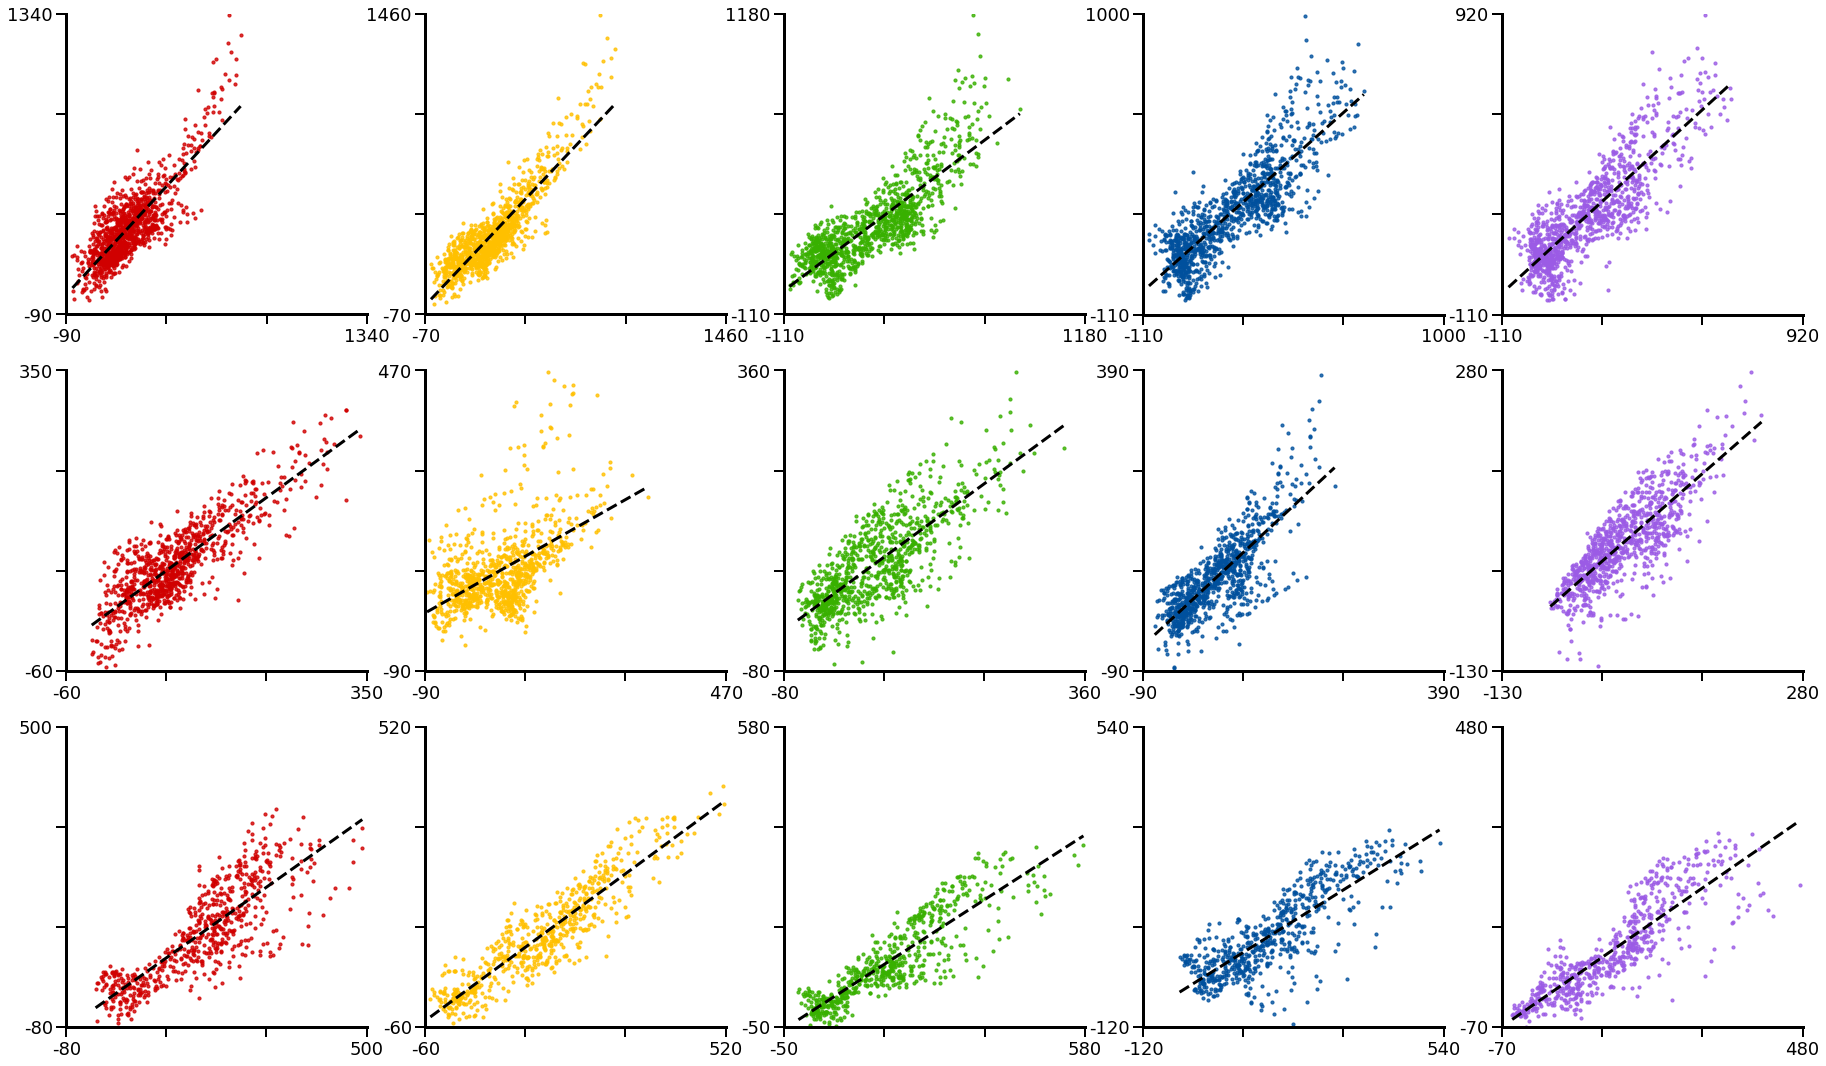

In [8]:
%matplotlib inline

subjects = ['sub-aa02','sub-aa06','sub-aa03']
hands = ['RH','LH']
hemis = {'RH': 'Lhemi', 'LH': 'Rhemi'}
hemi_rois = {'Lhemi': 'lh', 'Rhemi': 'rh'} 

all_subjs = pd.DataFrame()

beta_values = {}
colors = ['#D00000','#ffc000','#38B000','#00509D','#9B5BE5']

#=============================
# Data collection loop
#=============================

for subj in subjects:
    for hand in hands:
        hemi = hemis[hand]
        try:
            roi_prefix = hemi_rois[hemi]
            
            if subj == 'sub-aa03':
                subj_dir_pre1 = f'./data/Figure2B/{hemi}/{hand}/{subj}/pre3/{subj}_non-noise_normalized_betas_ROI_{roi_prefix}_3b.csv'
                subj_dir_pre2 = f'./data/Figure2B/{hemi}/{hand}/{subj}/pre4/{subj}_non-noise_normalized_betas_ROI_{roi_prefix}_3b.csv'
                subj_dir_post2 = f'./data/Figure2B/{hemi}/{hand}/{subj}/post2/{subj}_non-noise_normalized_betas_ROI_{roi_prefix}_3b.csv'
            else:
                subj_dir_pre1 = f'./data/Figure2B/{hemi}/{hand}/{subj}/pre1/{subj}_non-noise_normalized_betas_ROI_{roi_prefix}_3b.csv'
                subj_dir_pre2 = f'./data/Figure2B/{hemi}/{hand}/{subj}/pre2/{subj}_non-noise_normalized_betas_ROI_{roi_prefix}_3b.csv'
                subj_dir_post2 = f'./data/Figure2B/{hemi}/{hand}/{subj}/post3/{subj}_non-noise_normalized_betas_ROI_{roi_prefix}_3b.csv'

            betas_pre1 = np.genfromtxt(subj_dir_pre1, delimiter=',')
            betas_pre2 = np.genfromtxt(subj_dir_pre2, delimiter=',')
            betas_post2 = np.genfromtxt(subj_dir_post2, delimiter=',')
            
            betas_pre_avg = (betas_pre1 + betas_pre2) / 2
            
            conditions = np.array([1,2,3,4,5]*4)

            for k in range(1, 6):
                train_betas = betas_pre_avg[np.where(conditions==k)]
                test_betas = betas_post2[np.where(conditions==k)]
                
                train_betas_reshaped = train_betas[0,:]
                test_betas_reshaped = test_betas[0,:]
                beta_values[(subj, hand, k)] = (train_betas_reshaped, test_betas_reshaped)

        except Exception as e:
            print(f"Error with subject: {subj}, hand: {hand}. Error message: {e}")

#=============================
# Plotting
#=============================

def plot_subject_beta_values(subj, hand, ax_row, row_index):
    for k in range(1, 6):  # For each digit
        x_values, y_values = beta_values[(subj, hand, k)]
        sns.regplot(
            x=x_values, y=y_values, ax=ax_row[k - 1],
            scatter_kws={'s': 10, 'color': colors[k - 1]},
            line_kws={'color': 'black', 'linestyle': 'dashed', 'linewidth': 3}, 
            ci=None
        )
        
        # Calculate axis limits to ensure x and y axes match
        min_val = int(min(min(x_values), min(y_values)) // 10 * 10)  
        max_val = int(max(max(x_values), max(y_values)) // 10 * 10 + 10)  
        
        # Adjust min_val specifically for the first row
        if row_index == 0:  # First row
            min_val -= 20  # Reduce minimum by 20

        ax_row[k - 1].set_xlim([min_val, max_val])
        ax_row[k - 1].set_ylim([min_val, max_val])

        # Set aspect ratio to equal
        ax_row[k - 1].set_aspect('equal', adjustable='box')

        # Set ticks
        ticks = np.linspace(min_val, max_val, num=4, dtype=int)  # 4 ticks, integers
        ax_row[k - 1].set_xticks(ticks)
        ax_row[k - 1].set_yticks(ticks)
        
        # Label only the smallest and largest ticks
        ax_row[k - 1].set_xticklabels([ticks[0], '', '', ticks[-1]], fontsize=18)
        ax_row[k - 1].set_yticklabels([ticks[0], '', '', ticks[-1]], fontsize=18)

        # Make the axes thicker
        for spine in ax_row[k - 1].spines.values():
            spine.set_linewidth(3)

        # Adjust visibility of unlabeled ticks
        ax_row[k - 1].tick_params(axis='both', which='major', length=10, width=2)
        
         # Hide top and right spines
        ax_row[k - 1].spines['top'].set_visible(False)
        ax_row[k - 1].spines['right'].set_visible(False)

# Create a subplot grid with shared x and y axes
fig, axes = plt.subplots(3, 5, figsize=(25, 15))

# Adjust spacing
fig.subplots_adjust(hspace=0.8, wspace=0.4)

# Plot the data with row-specific adjustments
plot_subject_beta_values('sub-aa06', 'LH', axes[0], row_index=0)  # First row
plot_subject_beta_values('sub-aa02', 'RH', axes[1], row_index=1)  # Second row
plot_subject_beta_values('sub-aa03', 'LH', axes[2], row_index=2)  # Third row
plt.tight_layout()

# Save the plot
plt.savefig('./figures/Figure2B.png',dpi=300,bbox_inches="tight")

### Figure 2D

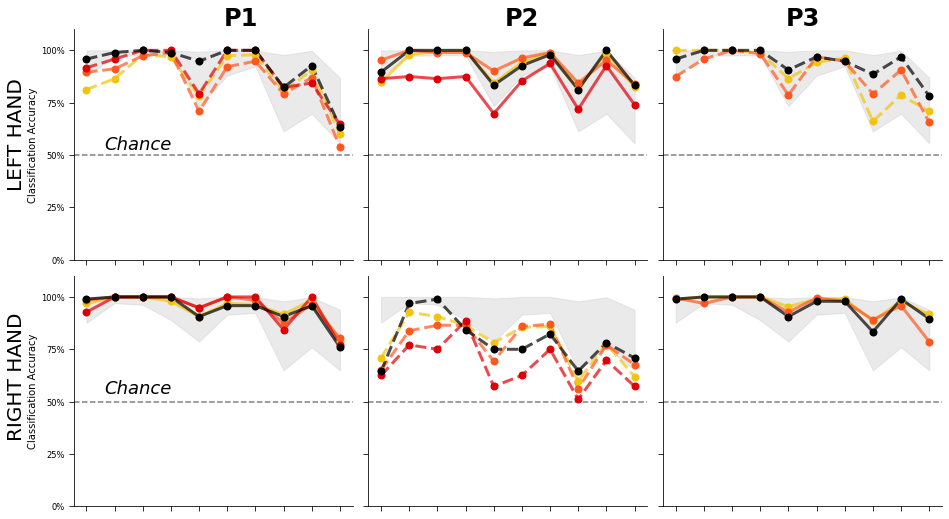

In [15]:
%matplotlib inline

df = pd.read_csv('./data/Figure2D_data.csv')

# Prepare the DataFrame for controls
pre_post2_L_ctrl = df.loc[(df.sess == 'pre_post2') & (df.hemi == 0) & (df.hand == 1) & (df.group == 0)]
pre_post2_R_ctrl = df.loc[(df.sess == 'pre_post2') & (df.hemi == 1) & (df.hand == 0) & (df.group == 0)]

# Extract amputee data for specific session comparisons
amp02_data_R_pre = df[(df.group == 1) & (df.hemi == 0) & (df.hand == 1) & (df.Subj == 'aa02') & (df.sess == 'pre1_pre2')]
amp02_data_L_pre = df[(df.group == 1) & (df.hemi == 1) & (df.hand == 0) & (df.Subj == 'aa02') & (df.sess == 'pre1_pre2')]
amp02_data_R_3m = df[(df.group == 1) & (df.hemi == 0) & (df.hand == 1) & (df.Subj == 'aa02') & (df.sess == 'pre_post1')]
amp02_data_L_3m = df[(df.group == 1) & (df.hemi == 1) & (df.hand == 0) & (df.Subj == 'aa02') & (df.sess == 'pre_post1')]
amp02_data_R_6m = df[(df.group == 1) & (df.hemi == 0) & (df.hand == 1) & (df.Subj == 'aa02') & (df.sess == 'pre_post2')]
amp02_data_L_6m = df[(df.group == 1) & (df.hemi == 1) & (df.hand == 0) & (df.Subj == 'aa02') & (df.sess == 'pre_post2')]
amp02_data_R_final = df[(df.group == 1) & (df.hemi == 0) & (df.hand == 1) & (df.Subj == 'aa02') & (df.sess == 'pre_post3')]
amp02_data_L_final = df[(df.group == 1) & (df.hemi == 1) & (df.hand == 0) & (df.Subj == 'aa02') & (df.sess == 'pre_post3')]

amp06_data_R_pre = df[(df.group == 1) & (df.hemi == 0) & (df.hand == 1) & (df.Subj == 'aa06') & (df.sess == 'pre1_pre2')]
amp06_data_L_pre = df[(df.group == 1) & (df.hemi == 1) & (df.hand == 0) & (df.Subj == 'aa06') & (df.sess == 'pre1_pre2')]
amp06_data_R_3m = df[(df.group == 1) & (df.hemi == 0) & (df.hand == 1) & (df.Subj == 'aa06') & (df.sess == 'pre_post1')]
amp06_data_L_3m = df[(df.group == 1) & (df.hemi == 1) & (df.hand == 0) & (df.Subj == 'aa06') & (df.sess == 'pre_post1')]
amp06_data_R_6m = df[(df.group == 1) & (df.hemi == 0) & (df.hand == 1) & (df.Subj == 'aa06') & (df.sess == 'pre_post2')]
amp06_data_L_6m = df[(df.group == 1) & (df.hemi == 1) & (df.hand == 0) & (df.Subj == 'aa06') & (df.sess == 'pre_post2')]
amp06_data_R_final = df[(df.group == 1) & (df.hemi == 0) & (df.hand == 1) & (df.Subj == 'aa06') & (df.sess == 'pre_post3')]
amp06_data_L_final = df[(df.group == 1) & (df.hemi == 1) & (df.hand == 0) & (df.Subj == 'aa06') & (df.sess == 'pre_post3')]

amp03_data_R_pre = df[(df.group == 1) & (df.hemi == 0) & (df.hand == 1) & (df.Subj == 'aa03') & (df.sess == 'pre1_pre2')]
amp03_data_L_pre = df[(df.group == 1) & (df.hemi == 1) & (df.hand == 0) & (df.Subj == 'aa03') & (df.sess == 'pre1_pre2')]
amp03_data_R_3m = df[(df.group == 1) & (df.hemi == 0) & (df.hand == 1) & (df.Subj == 'aa03') & (df.sess == 'pre_post1')]
amp03_data_L_3m = df[(df.group == 1) & (df.hemi == 1) & (df.hand == 0) & (df.Subj == 'aa03') & (df.sess == 'pre_post1')]
amp03_data_R_6m = df[(df.group == 1) & (df.hemi == 0) & (df.hand == 1) & (df.Subj == 'aa03') & (df.sess == 'pre_post2')]
amp03_data_L_6m = df[(df.group == 1) & (df.hemi == 1) & (df.hand == 0) & (df.Subj == 'aa03') & (df.sess == 'pre_post2')]

# Create a 2x2 plot
fig, axes = plt.subplots(2, 3, figsize=(13, 7), sharey=True, sharex=True)
fig.subplots_adjust(hspace=0.5)

digit_colors = ['#FFC2C2','#FFF8AD','#D5FFC2','#C2E1FF','#EADCF9']
violin_palette = ['#DBDFE6']

# Extract mean and 95% confidence interval
mean_values_L = pre_post2_L_ctrl.groupby('digit_pair')['distance'].mean()
ci_upper_L = pre_post2_L_ctrl.groupby('digit_pair')['distance'].quantile(0.975)
ci_lower_L = pre_post2_L_ctrl.groupby('digit_pair')['distance'].quantile(0.025)

mean_values_R = pre_post2_R_ctrl.groupby('digit_pair')['distance'].mean()
ci_upper_R = pre_post2_R_ctrl.groupby('digit_pair')['distance'].quantile(0.975)
ci_lower_R = pre_post2_R_ctrl.groupby('digit_pair')['distance'].quantile(0.025)

# Plot only the 95% prediction interval as an area
axes[0, 0].fill_between(mean_values_L.index, ci_lower_L, ci_upper_L, color='#BBBBBF', alpha=0.3)
axes[0, 1].fill_between(mean_values_L.index, ci_lower_L, ci_upper_L, color='#BBBBBF', alpha=0.3)
axes[1, 0].fill_between(mean_values_R.index, ci_lower_R, ci_upper_R, color='#BBBBBF', alpha=0.3)
axes[1, 1].fill_between(mean_values_R.index, ci_lower_R, ci_upper_R, color='#BBBBBF', alpha=0.3)
axes[0, 2].fill_between(mean_values_L.index, ci_lower_L, ci_upper_L, color='#BBBBBF', alpha=0.3)
axes[1, 2].fill_between(mean_values_R.index, ci_lower_R, ci_upper_R, color='#BBBBBF', alpha=0.3)

# Strip plots for amp02

sns.stripplot(x='digit_pair', y='distance', data=amp02_data_R_3m, ax=axes[1, 1], color='#F1C40F', jitter=False,s=8)
axes[1,1].plot(amp02_data_R_3m['digit_pair'], amp02_data_R_3m['distance'],color='#F1C40F', linewidth=3,linestyle='--', alpha=.7)
sns.stripplot(x='digit_pair', y='distance', data=amp02_data_R_6m, ax=axes[1, 1], color='#FF571F', jitter=False,s=8)
axes[1,1].plot(amp02_data_R_6m['digit_pair'], amp02_data_R_6m['distance'], color='#FF571F', linewidth=3,linestyle='--',alpha=.7)
sns.stripplot(x='digit_pair', y='distance', data=amp02_data_R_final, ax=axes[1, 1], color='#DD0007', jitter=False,s=8)
axes[1,1].plot(amp02_data_R_final['digit_pair'], amp02_data_R_final['distance'], color='#DD0007', linewidth=3,linestyle='--',alpha=.7)
sns.stripplot(x='digit_pair', y='distance', data=amp02_data_R_pre, ax=axes[1, 1], color='black', jitter=False,s=8)
axes[1,1].plot(amp02_data_R_pre['digit_pair'], amp02_data_R_pre['distance'], color='black',linewidth=3, linestyle='--' ,alpha=.7)

sns.stripplot(x='digit_pair', y='distance', data=amp02_data_L_3m, ax=axes[0, 1], color='#F1C40F', jitter=False,s=8)
axes[0,1].plot(amp02_data_L_3m['digit_pair'], amp02_data_L_3m['distance'], color='#F1C40F', linewidth=3,linestyle='-' ,alpha=.7)
sns.stripplot(x='digit_pair', y='distance', data=amp02_data_L_6m, ax=axes[0, 1], color='#FF571F', jitter=False,s=8)
axes[0,1].plot(amp02_data_L_6m['digit_pair'], amp02_data_L_6m['distance'], color='#FF571F', linewidth=3,linestyle='-' ,alpha=.7)
sns.stripplot(x='digit_pair', y='distance', data=amp02_data_L_final, ax=axes[0, 1], color='#DD0007', jitter=False,s=8)
axes[0,1].plot(amp02_data_L_final['digit_pair'], amp02_data_L_final['distance'], color='#DD0007', linewidth=3,linestyle='-' ,alpha=.7)
sns.stripplot(x='digit_pair', y='distance', data=amp02_data_L_pre, ax=axes[0, 1], color='black', jitter=False,s=8)
axes[0,1].plot(amp02_data_L_pre['digit_pair'], amp02_data_L_pre['distance'], color='black',linewidth=3, linestyle='-' ,alpha=.7)

sns.stripplot(x='digit_pair', y='distance', data=amp06_data_R_3m, ax=axes[1, 0], color='#F1C40F', jitter=False,s=8)
axes[1,0].plot(amp06_data_R_3m['digit_pair'], amp06_data_R_3m['distance'], color='#F1C40F', linewidth=3,linestyle='-' ,alpha=.7)
sns.stripplot(x='digit_pair', y='distance', data=amp06_data_R_6m, ax=axes[1, 0], color='#FF571F', jitter=False,s=8)
axes[1,0].plot(amp06_data_R_6m['digit_pair'], amp06_data_R_6m['distance'], color='#FF571F', linewidth=3,linestyle='-' ,alpha=.7)
sns.stripplot(x='digit_pair', y='distance', data=amp06_data_R_final, ax=axes[1, 0], color='#DD0007', jitter=False,s=8)
axes[1,0].plot(amp06_data_R_final['digit_pair'], amp06_data_R_final['distance'], color='#DD0007', linewidth=3,linestyle='-' ,alpha=.7)
sns.stripplot(x='digit_pair', y='distance', data=amp06_data_R_pre, ax=axes[1, 0], color='black', jitter=False,s=8)
axes[1,0].plot(amp06_data_R_pre['digit_pair'], amp06_data_R_pre['distance'], color='black', linewidth=3,linestyle='-' ,alpha=.7)

sns.stripplot(x='digit_pair', y='distance', data=amp06_data_L_3m, ax=axes[0, 0], color='#F1C40F', jitter=False,s=8)
axes[0,0].plot(amp06_data_L_3m['digit_pair'], amp06_data_L_3m['distance'], color='#F1C40F',linewidth=3, linestyle='--' ,alpha=.7)
sns.stripplot(x='digit_pair', y='distance', data=amp06_data_L_6m, ax=axes[0, 0], color='#FF571F', jitter=False,s=8)
axes[0,0].plot(amp06_data_L_6m['digit_pair'], amp06_data_L_6m['distance'], color='#FF571F', linewidth=3,linestyle='--' ,alpha=.7)
sns.stripplot(x='digit_pair', y='distance', data=amp06_data_L_final, ax=axes[0, 0], color='#DD0007', jitter=False,s=8)
axes[0,0].plot(amp06_data_L_final['digit_pair'], amp06_data_L_final['distance'], color='#DD0007', linewidth=3,linestyle='--' ,alpha=.7)
sns.stripplot(x='digit_pair', y='distance', data=amp06_data_L_pre, ax=axes[0, 0], color='black', jitter=False,s=8)
axes[0,0].plot(amp06_data_L_pre['digit_pair'], amp06_data_L_pre['distance'], color='black', linewidth=3,linestyle='--' ,alpha=.7)

sns.stripplot(x='digit_pair', y='distance', data=amp03_data_R_3m, ax=axes[1, 2], color='#F1C40F', jitter=False,s=8)
axes[1,2].plot(amp03_data_R_3m['digit_pair'], amp03_data_R_3m['distance'], color='#F1C40F', linewidth=3,linestyle='-' ,alpha=.7)
sns.stripplot(x='digit_pair', y='distance', data=amp03_data_R_6m, ax=axes[1, 2], color='#FF571F', jitter=False,s=8)
axes[1,2].plot(amp03_data_R_6m['digit_pair'], amp03_data_R_6m['distance'], color='#FF571F', linewidth=3,linestyle='-' ,alpha=.7)
sns.stripplot(x='digit_pair', y='distance', data=amp03_data_R_pre, ax=axes[1, 2], color='black', jitter=False,s=8)
axes[1,2].plot(amp03_data_R_pre['digit_pair'], amp03_data_R_pre['distance'], color='black', linewidth=3,linestyle='-' ,alpha=.7)

sns.stripplot(x='digit_pair', y='distance', data=amp03_data_L_3m, ax=axes[0, 2], color='#F1C40F', jitter=False,s=8)
axes[0,2].plot(amp03_data_L_3m['digit_pair'], amp03_data_L_3m['distance'], color='#F1C40F',linewidth=3, linestyle='--' ,alpha=.7)
sns.stripplot(x='digit_pair', y='distance', data=amp03_data_L_6m, ax=axes[0, 2], color='#FF571F', jitter=False,s=8)
axes[0,2].plot(amp03_data_L_6m['digit_pair'], amp03_data_L_6m['distance'], color='#FF571F', linewidth=3,linestyle='--' ,alpha=.7)
sns.stripplot(x='digit_pair', y='distance', data=amp03_data_L_pre, ax=axes[0, 2], color='black', jitter=False,s=8)
axes[0,2].plot(amp03_data_L_pre['digit_pair'], amp03_data_L_pre['distance'], color='black', linewidth=3,linestyle='--' ,alpha=.7)
# Set y-axis limits
plt.ylim(0, 1)

axes[0,0].set_xticks([0,1,2,3,4,5,6,7,8,9])
axes[0,0].set_xticklabels(['','','','','','','','','',''])

axes[1,0].set_xticks([0,1,2,3,4,5,6,7,8,9])
axes[1,1].set_xticks([0,1,2,3,4,5,6,7,8,9])

axes[0,0].set_ylim(0,1.1)
axes[0,1].set_ylim(0,1.1)
axes[1,0].set_ylim(0,1.1)
axes[1,1].set_ylim(0,1.1)

axes[0,0].set(xlabel="Digit Pairs",ylabel="Classification Accuracy")   
axes[1,0].set(xlabel="",ylabel="Classification Accuracy")
axes[1,1].set(xlabel="")   
axes[0,1].set(xlabel="")   
axes[1,2].set(xlabel="")   

axes[0,0].set_yticks([0,.25,.5,.75,1])   
axes[1,0].set_yticks([0,.25,.5,.75,1])   
axes[0,0].set_yticklabels(['0%','25%','50%','75%','100%'])   
axes[1,0].set_yticklabels(['0%','25%','50%','75%','100%'])  
axes[0,0].set_xlabel('')   
axes[0,1].set_ylabel('')   
axes[1,1].set_ylabel('')   


fig.text(-0.0, 0.77, 'LEFT HAND', rotation=90,horizontalalignment='center', verticalalignment='center',fontsize=20)
fig.text(-0.0, 0.29, 'RIGHT HAND', rotation=90,horizontalalignment='center', verticalalignment='center',fontsize=20)

fig.text(.24, 1, 'P1', horizontalalignment='center', verticalalignment='center',fontsize=24,weight='bold')
fig.text(.54, 1, 'P2', horizontalalignment='center', verticalalignment='center',fontsize=24,weight='bold')
fig.text(.84, 1, 'P3', horizontalalignment='center', verticalalignment='center',fontsize=24,weight='bold')

axes[0,0].axhline(y=.5, xmin=0,linestyle='--',color='grey') 
axes[1,0].axhline(y=.5, xmin=0,linestyle='--',color='grey')
axes[1,1].axhline(y=.5, xmin=0,linestyle='--',color='grey')
axes[0,1].axhline(y=.5, xmin=0,linestyle='--',color='grey')
axes[1,2].axhline(y=.5, xmin=0,linestyle='--',color='grey')
axes[0,2].axhline(y=.5, xmin=0,linestyle='--',color='grey')

fig.text(.13,.75,'Chance',style='italic',horizontalalignment='center',verticalalignment='center',fontsize=18)
fig.text(.13,.267,'Chance',style='italic',horizontalalignment='center',verticalalignment='center',fontsize=18)

plt.savefig('./figures/Figure2D.png',dpi=300,bbox_inches="tight")

### Figure 3A

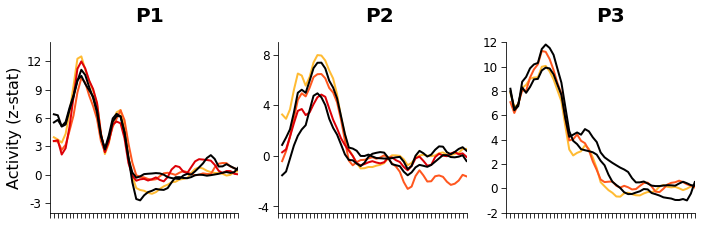

In [14]:
%matplotlib inline
df = pd.read_csv('./data/Figure2A_data.csv')

# BUILD A DICTIONARY TO USE FOR PLOTTING FOR THE CONTROLS, AMP01 AND AMP02
sessions = ['pre1','pre2','pre3','pre4','post1','post2','post3']
copes = [11,12,14,15,32]
hemis = ['lh','rh']

ctrls_dfs = {}
for sess in sessions:
    for cop in copes:
        for hem in hemis:
            ctrls_df = df.loc[(df.group == 0) & (df.session == sess) & (df.cope == cop) & (df.hemi == hem)]
            df_name = 'ctrls_' + sess + '_' + str(hem) + '_' + str(cop)
            ctrls_dfs[df_name] = ctrls_df
        
amp01_dfs = {}
for sess in sessions:
    for cop in copes:
        for hem in hemis:
            amp01_df = df.loc[(df.subj == 'sub-aa02') & (df.session == sess) & (df.cope == cop)& (df.hemi == hem)]
            df_name = 'amp01_' + sess + '_' + str(hem) + '_' + str(cop)
            amp01_dfs[df_name] = amp01_df
        
amp02_dfs = {}
for sess in sessions:
    for cop in copes:
        for hem in hemis:
            amp02_df = df.loc[(df.subj == 'sub-aa06') & (df.session == sess) & (df.cope == cop)& (df.hemi == hem)]
            df_name = 'amp02_' + sess + '_' + str(hem) + '_' + str(cop)
            amp02_dfs[df_name] = amp02_df
            
amp03_dfs = {}
for sess in sessions:
    for cop in copes:
        for hem in hemis:
            amp03_df = df.loc[(df.subj == 'sub-aa03') & (df.session == sess) & (df.cope == cop)& (df.hemi == hem)]
            df_name = 'amp03_' + sess + '_' + str(hem) + '_' + str(cop)
            amp03_dfs[df_name] = amp03_df
    
#DEFINE PLOTTING PARAMETERS

pre1_color = ['black']
pre2_color = ['black']
post1_color = ['#FFBB33']
post2_color = ['#FF571F']
post3_color = ['#DD0007']

fig, axes = plt.subplots(1, 3,figsize=(10, 3), sharey='col', sharex=True)
fig.subplots_adjust(hspace=10,wspace=0.2)
plt.style.use("https://raw.githubusercontent.com/NeuromatchAcademy/course-content/master/nma.mplstyle")

def line_plot(axis, dataframe,sess_color,ls,smoothing=None):
    sns.set_palette(sess_color)
    if smoothing is None:
        sns.lineplot(
            ax=axis,
            x='band',
            y='fslmeants',
            hue='group',
            linewidth=2,
            #color=sess_color,
            data=dataframe,
            legend=None
        )
    elif smoothing == 'rolling_mean':
        sns.lineplot(
            ax=axis,
            x='band',
            y=dataframe['fslmeants'].rolling(2, center=True).mean(),
            hue='group',
            linewidth=2,
            #color=sess_color,
            data=dataframe,
            legend=None, linestyle=ls
        )
    
#PLOTTING DATA

#Amp02

line_plot(axes[0],amp02_dfs['amp02_post1_rh_11'],post1_color,'-',smoothing='rolling_mean')
line_plot(axes[0],amp02_dfs['amp02_post2_rh_11'],post2_color,'-',smoothing='rolling_mean')
line_plot(axes[0],amp02_dfs['amp02_post3_rh_11'],post3_color,'-',smoothing='rolling_mean')
line_plot(axes[0],amp02_dfs['amp02_pre1_rh_11'],pre1_color,'-',smoothing='rolling_mean')
line_plot(axes[0],amp02_dfs['amp02_pre2_rh_11'],pre2_color,'-',smoothing='rolling_mean')
#Amp01

line_plot(axes[1],amp01_dfs['amp01_post1_lh_11'],post1_color,'-',smoothing='rolling_mean')
line_plot(axes[1],amp01_dfs['amp01_post2_lh_11'],post2_color,'-',smoothing='rolling_mean')
line_plot(axes[1],amp01_dfs['amp01_post3_lh_11'],post3_color,'-',smoothing='rolling_mean')
line_plot(axes[1],amp01_dfs['amp01_pre1_lh_11'],pre1_color,'-',smoothing='rolling_mean')
line_plot(axes[1],amp01_dfs['amp01_pre2_lh_11'],pre2_color,'-',smoothing='rolling_mean')
#Amp03

line_plot(axes[2],amp03_dfs['amp03_post1_rh_11'],post1_color,'-',smoothing='rolling_mean')
line_plot(axes[2],amp03_dfs['amp03_post2_rh_11'],post2_color,'-',smoothing='rolling_mean')
line_plot(axes[2],amp03_dfs['amp03_pre1_rh_11'],pre1_color,'-',smoothing='rolling_mean')
line_plot(axes[2],amp03_dfs['amp03_pre2_rh_11'],pre2_color,'-',smoothing='rolling_mean')

axes[0].set_xticks([0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,\
                     21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,\
                     40,41,42,43,44,45,46,47,48])
axes[0].set_xticklabels(['','','','','','','','','','','','','','','','','','','','',\
                          '','','','','','','','','','','','','','','','','','','','',\
                          '','','','','','','','',''])

axes[0].set_xlim(0, 48)

axes[0].set_ylabel("Activity (z-stat)",fontsize=16)   
axes[1].set_ylabel("",fontsize=12)   
axes[2].set_ylabel("",fontsize=12)   
axes[0].set_yticks([-3,0,3,6,9,12]) 
axes[0].set_yticklabels([-3,0,3,6,9,12],fontsize=12)
axes[1].set_yticks([-4,0,4,8,12]) 
axes[1].set_yticklabels([-4,0,4,8,12],fontsize=12) 
axes[2].set_yticks([-2,0,2,4,6,8,10,12]) 
axes[2].set_yticklabels([-2,0,2,4,6,8,10,12],fontsize=12) 
axes[1].set_ylim(-4.5, 9)
axes[0].set_ylim(-4, 14)
axes[2].set_ylim(-2, 12)

axes[0].set_xlabel("",fontsize=14) 
axes[1].set_xlabel("",fontsize=14) 
axes[2].set_xlabel("",fontsize=14) 

fig.text(.22, 1.02, 'P1', horizontalalignment='center', verticalalignment='center',fontsize=20,weight='bold')
fig.text(.54, 1.02, 'P2', horizontalalignment='center', verticalalignment='center',fontsize=20,weight='bold')
fig.text(.86, 1.02, 'P3', horizontalalignment='center', verticalalignment='center',fontsize=20,weight='bold')

plt.savefig('./figures/Figure3A.png',dpi=300,bbox_inches="tight")

### Figure 3B

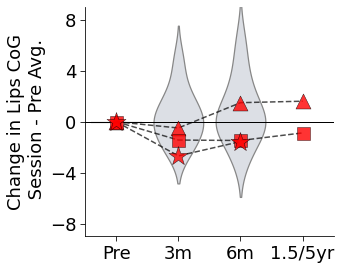

In [20]:
%matplotlib inline
# Load data
all_subjs = pd.read_csv('./data/Figure3B_data.csv')

# Filter data
ctrls = all_subjs.loc[(all_subjs.group == 0)]
amp01 = all_subjs.loc[(all_subjs.subj == 'sub-aa02')]
amp02 = all_subjs.loc[(all_subjs.subj == 'sub-aa06')]
amp03 = all_subjs.loc[(all_subjs.subj == 'sub-aa03')]

# Setup figure
fig, axes = plt.subplots(1, 1, figsize=(5, 4), sharex=True)
plt.style.use("https://raw.githubusercontent.com/NeuromatchAcademy/course-content/master/nma.mplstyle")

# Define colors
violin_palette = ['#DBDFE6']
amp01_color = ['red', 'red']
amp02_color = ['red', 'red']

# Plot violin plot for controls
sns.violinplot(y='diff_cog', x='fslmeants_diff_pre', data=ctrls, palette=violin_palette, ax=axes, inner=None)

# Plot strip plots for amp01 and amp02
sns.stripplot(y='diff_cog', x='fslmeants_diff_pre', data=amp02, jitter=.15, dodge=False, marker="^", alpha=.8, palette=amp02_color, edgecolor="black", linewidth=.5, s=15, ax=axes)
sns.stripplot(y='diff_cog', x='fslmeants_diff_pre', data=amp01, jitter=.15, dodge=False, marker="s", alpha=.8, palette=amp01_color, edgecolor="black", linewidth=.5, s=13, ax=axes)
sns.stripplot(y='diff_cog', x='fslmeants_diff_pre', data=amp03, jitter=.15, dodge=False, marker="*", alpha=.8, palette=amp01_color, edgecolor="black", linewidth=.5, s=20,ax=axes)

# Plot lines for amp01 and amp02
plt.plot(amp01['fslmeants_diff_pre'], amp01['diff_cog'], 'k--', alpha=.7)
plt.plot(amp02['fslmeants_diff_pre'], amp02['diff_cog'], 'k--', alpha=.7)
plt.plot(amp03['fslmeants_diff_pre'], amp03['diff_cog'], 'k--', alpha=.7)

# Set labels and limits
plt.ylabel('Change in Lips CoG\n Session - Pre Avg.', fontsize=18)
plt.xlabel('')
plt.xticks([0, 1, 2,3], ['Pre', '3m', '6m','1.5/5yr'], fontsize=18
          )
plt.yticks([-8, -4, 0,4,8],fontsize=18)
plt.axhline(0, color='black', linewidth=1)
plt.ylim(-9, 9)

plt.xlim(-.5,3.5)
plt.savefig('./figures/Figure3B.png',dpi=300,bbox_inches="tight")

### Figure 3C

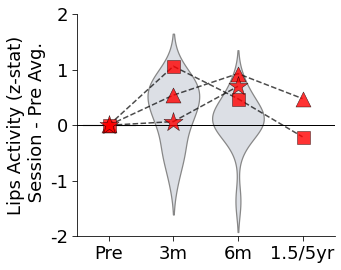

In [16]:
%matplotlib inline

all_subjs = pd.read_csv('./data/Figure3C/Figure3C_data.csv')

#=========================================================
#LOAD DATA
#=========================================================
ctrls = all_subjs.loc[(all_subjs.group == 0) & (all_subjs.hemi == 'rh')]
amp01 = all_subjs.loc[(all_subjs.subj == 'sub-aa02') & (all_subjs.hemi == 'lh')]
amp02 = all_subjs.loc[(all_subjs.subj == 'sub-aa06') & (all_subjs.hemi == 'rh')]
amp03 = all_subjs.loc[(all_subjs.subj == 'sub-aa03') & (all_subjs.hemi == 'rh')]

#=========================================================
#DEFINE MOASAIC FIGURE
#=========================================================
fig, axes = plt.subplots(1, 1,figsize=(5, 4), sharex=True)
#fig.subplots_adjust(hspace=10,wspace=0.2)
plt.style.use("https://raw.githubusercontent.com/NeuromatchAcademy/course-content/master/nma.mplstyle")

#=========================================================
#DEFINE MOASAIC FIGURE
#=========================================================
colors = ['#DBDFE6','#DBDFE6','#DBDFE6']
ctrl_color = ['#767382','#767382','#767382']
amp01_color = ['red','red']
amp02_color = ['red','red']

#=========================================================
#PLOTTING PARAMETERS
#=========================================================
sns.set_palette(colors)
# Define colors
violin_palette = ['#DBDFE6']
amp01_color = ['red', 'red']
amp02_color = ['red', 'red']

# Plot violin plot for controls
sns.violinplot(y='fslmeants_diff_pre', x='sess', data=ctrls, palette=violin_palette, ax=axes, inner=None)

# Plot strip plots for amp01 and amp02
sns.stripplot(y='fslmeants_diff_pre', x='sess', data=amp02, jitter=False, dodge=False, marker="^", alpha=.8, palette=amp02_color, edgecolor="black", linewidth=.5, s=15, ax=axes)
sns.stripplot(y='fslmeants_diff_pre', x='sess', data=amp01, jitter=False, dodge=False, marker="s", alpha=.8, palette=amp01_color, edgecolor="black", linewidth=.5, s=13, ax=axes)
sns.stripplot(y='fslmeants_diff_pre', x='sess', data=amp03, jitter=False, dodge=False, marker="*", alpha=.8, palette=amp01_color, edgecolor="black", linewidth=.5, s=20, ax=axes)

# Plot lines for amp01 and amp02
plt.plot(amp01['sess'], amp01['fslmeants_diff_pre'], 'k--', alpha=.7)
plt.plot(amp02['sess'], amp02['fslmeants_diff_pre'], 'k--', alpha=.7)
plt.plot(amp03['sess'], amp03['fslmeants_diff_pre'], 'k--', alpha=.7)

plt.ylabel('Lips Activity (z-stat)\n Session - Pre Avg.',fontsize=18)
plt.xlabel('',fontsize=20)
plt.xticks([0,1,2,3],['Pre','3m','6m','1.5/5yr'],fontsize=18)
plt.axhline(0,color='black',linewidth=1)
plt.ylim(-2,2)
plt.yticks([-2,-1,0,1,2],['-2','-1','0','1','2'],fontsize=18)
plt.xlim(-.5,3.5)
plt.savefig('./figures/Figure3C.png',dpi=300,bbox_inches="tight")

### Figure 3E

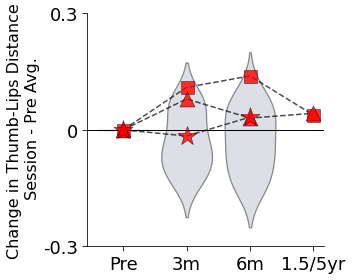

In [21]:
%matplotlib inline
# Load data
data_path = "./data/Figure3E_data.csv"
df = pd.read_csv(data_path)
# Drop rows where subj is 'aa03' and sess_comparison is 'pre1-pre2'
df = df[~((df['subj'] == 'aa03') & (df['sess_comparison'] == 'pre1-pre2'))]

# Change 'pre3-pre4' to 'pre1-pre2' for rows where subj is 'aa03'
df.loc[(df['subj'] == 'aa03') & (df['sess_comparison'] == 'pre3-pre4'), 'sess_comparison'] = 'pre1-pre2'

# Filter for ROI 3b
roi_3b_df = df[df["ROI"] == "3b"]

# Define base session comparison
base_comparison = "pre1-pre2"

# Initialize a list to store the results
results = []

# Loop through each subject
for subj in roi_3b_df["subj"].unique():
    subj_data = roi_3b_df[roi_3b_df["subj"] == subj]
    if base_comparison not in subj_data["sess_comparison"].values:
        continue

    # Get the base D1-Lips value
    base_value = subj_data[subj_data["sess_comparison"] == base_comparison]["D1-Lips"].values[0]

    # Add the "pres" row
    for hand in subj_data["hand"].unique():
        roi = subj_data[subj_data["hand"] == hand]["ROI"].iloc[0]
        results.append({
            "subj": subj,
            "sess_comparison_diff": "pres",
            "hand": hand,
            "ROI": roi,
            "D1-Lips_diff": 0
        })

    # Compute differences for other session comparisons
    for _, row in subj_data.iterrows():
        if row["sess_comparison"] == base_comparison:
            continue
        diff = row["D1-Lips"] - base_value
        results.append({
            "subj": subj,
            "sess_comparison_diff": f"{base_comparison}_vs_{row['sess_comparison']}",
            "hand": row["hand"],
            "ROI": row["ROI"],
            "D1-Lips_diff": diff
        })

# Create a new DataFrame with the results
diff_df = pd.DataFrame(results)
desired_sess_comparisons = ['pres', 'pre1-pre2_vs_pre_post1', 'pre1-pre2_vs_pre_post2', 'pre1-pre2_vs_pre_post3']
diff_df = diff_df[diff_df['sess_comparison_diff'].isin(desired_sess_comparisons)]

# Ensure the sess_comparison_diff column is in the correct order
diff_df['sess_comparison_diff'] = pd.Categorical(
    diff_df['sess_comparison_diff'],
    categories=desired_sess_comparisons,
    ordered=True
)
# Plotting
fig, ax = plt.subplots(1, 1, figsize=(5, 4), sharex=True)

# Define subject-specific data
ctrls = diff_df.loc[(diff_df["subj"].str.startswith("co")) & (diff_df["hand"] == "RH")]
amp01 = diff_df.loc[(diff_df["subj"] == "aa02") & (diff_df["hand"] == "RH")]
amp02 = diff_df.loc[(diff_df["subj"] == "aa06") & (diff_df["hand"] == "LH")]
amp03 = diff_df.loc[(diff_df["subj"] == "aa03") & (diff_df["hand"] == "LH")]

# Define colors
violin_palette = ["#DBDFE6"]
amp_colors = {"aa02": "red", "aa06": "red", "aa03": "red"}

# Plot violin plot for controls
sns.violinplot(y="D1-Lips_diff", x="sess_comparison_diff", data=ctrls, palette=violin_palette, ax=ax, inner=None)

# Plot strip plots for amputees
sns.stripplot(y="D1-Lips_diff", x="sess_comparison_diff", data=amp01, jitter=False, marker="s", alpha=0.8,
              color=amp_colors["aa02"], edgecolor="black", linewidth=0.5, s=13, ax=ax)
sns.stripplot(y="D1-Lips_diff", x="sess_comparison_diff", data=amp02, jitter=False, marker="^", alpha=0.8,
              color=amp_colors["aa06"], edgecolor="black", linewidth=0.5, s=15, ax=ax)
sns.stripplot(y="D1-Lips_diff", x="sess_comparison_diff", data=amp03, jitter=False, marker="*", alpha=0.8,
              color=amp_colors["aa03"], edgecolor="black", linewidth=0.5, s=20, ax=ax)

# Plot lines connecting the points for amputees
ax.plot(amp01["sess_comparison_diff"], amp01["D1-Lips_diff"], "k--", alpha=0.7)
ax.plot(amp02["sess_comparison_diff"], amp02["D1-Lips_diff"], "k--", alpha=0.7)
ax.plot(amp03["sess_comparison_diff"], amp03["D1-Lips_diff"], "k--", alpha=0.7)

# Customize the plot
plt.ylabel('Change in Thumb-Lips Distance\n Session - Pre Avg.', fontsize=16)
ax.set_xlabel("", fontsize=14)
ax.axhline(0, color="black", linewidth=1)
ax.set_ylim(-0.3, 0.3)

# Ensure x and y ticks are visible
ax.set_xticks([0, 1, 2, 3])
ax.set_xticklabels(['Pre', '3m', '6m', '1.5/5yr'], fontsize=18)
ax.set_yticks([-0.3, 0, 0.3])
ax.set_yticklabels(['-0.3', '0', '0.3'], fontsize=18)

# Save the plot
output_path = "./figures/Figure3E.png"
plt.tight_layout()
plt.savefig(output_path, dpi=300)
plt.show()

### Figure 3F - left

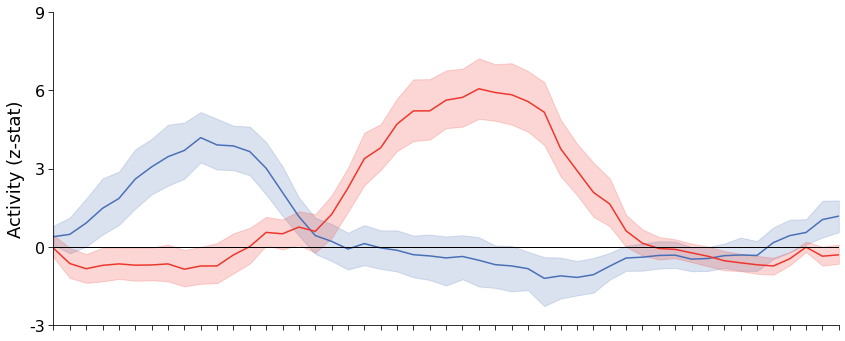

In [22]:
%matplotlib inline

df = pd.read_csv('./data/Figure3F_left_data.csv')  
demographics = pd.read_csv('./data/Figure3F_demographics.csv')  

# Define subjects that need hemisphere flipping
flip_hemi_subjects = ['MA10', 'MA22', 'MA24', 'MA27']

# Filter data
amp_df = df[df['subj'].str.contains('MA|AA', case=False, na=False)]

# Flip hemisphere for specified subjects
amp_df.loc[amp_df['subj'].isin(flip_hemi_subjects), 'hemi'] = amp_df.loc[amp_df['subj'].isin(flip_hemi_subjects), 'hemi'].replace({'lh': 'rh', 'rh': 'lh'})

# Function to determine side for amputees
def determine_side(row, missing_side=None):
    if missing_side == 0:  # Missing left
        if row['hemi'] == 'lh':
            if row['cope'] == 'lefthand':
                return 'ipsi_ndom'
            elif row['cope'] == 'righthand':
                return 'contra_doi'
            elif row['cope'] == 'lips':
                return 'doi'
        elif row['hemi'] == 'rh':
            if row['cope'] == 'lefthand':
                return 'contra_ndom'
            elif row['cope'] == 'righthand':
                return 'ipsi_doi'
            elif row['cope'] == 'lips':
                return 'ndom'
    elif missing_side == 1:  # Missing right
        if row['hemi'] == 'lh':
            if row['cope'] == 'lefthand':
                return 'ipsi_doi'
            elif row['cope'] == 'righthand':
                return 'contra_ndom'
            elif row['cope'] == 'lips':
                return 'ndom'
        elif row['hemi'] == 'rh':
            if row['cope'] == 'lefthand':
                return 'contra_doi'
            elif row['cope'] == 'righthand':
                return 'ipsi_ndom'
            elif row['cope'] == 'lips':
                return 'doi'

# Add side column to amp_df
amp_df = amp_df.copy()  # Ensure we're not modifying the original DataFrame

def get_missing_side(subj):
    match = demographics.loc[demographics['Subj Code'].str.lower() == subj.lower(), 'Missing Side']
    return match.values[0] if not match.empty else None

amp_df.loc[:, 'side'] = amp_df.apply(lambda row: determine_side(row, get_missing_side(row['subj'])), axis=1)

# Define plotting parameters
fig, ax = plt.subplots(figsize=(12, 5))
plt.style.use("https://raw.githubusercontent.com/NeuromatchAcademy/course-content/master/nma.mplstyle")

def line_plot(axis, dataframe, color, label, smoothing=None):
    if not dataframe.empty:
        if smoothing is None:
            sns.lineplot(
                ax=axis,
                x='band',
                y='fslmeants',
                color=color,
                data=dataframe,
                label=label,
                legend=None
            )
        elif smoothing == 'rolling_mean':
            sns.lineplot(
                ax=axis,
                x='band',
                y=dataframe['fslmeants'].rolling(1, center=True).mean(),
                color=color,
                data=dataframe,
                label=label,
                legend=None
            )

# Amputees
line_plot(ax, amp_df[(amp_df['side'] == 'ndom') & (amp_df['cope'] == 'lips')], '#496FB6', 'lips', smoothing=None)

# Combine left hand and right hand data for contra_ndom
contra_ndom_hand_df = amp_df[(amp_df['side'] == 'contra_ndom') & (amp_df['cope'].isin(['lefthand', 'righthand']))]
line_plot(ax, contra_ndom_hand_df, '#ED362B', 'hand', smoothing=None)

# Calculate mean and SEM for group average
mean_lips = amp_df[(amp_df['side'] == 'ndom') & (amp_df['cope'] == 'lips')].groupby('band')['fslmeants'].mean()
sem_lips = amp_df[(amp_df['side'] == 'ndom') & (amp_df['cope'] == 'lips')].groupby('band')['fslmeants'].sem()
mean_hand = contra_ndom_hand_df.groupby('band')['fslmeants'].mean()
sem_hand = contra_ndom_hand_df.groupby('band')['fslmeants'].sem()

# Final plotting parameters
ax.set_ylabel("Activity (z-stat)", fontsize=18)
ax.set_xlabel("", fontsize=14)
ax.set_xticks(range(49))
ax.set_xticklabels([''] * 49)
ax.set_xlim(0, 48)
ax.set_ylim(-3, 9)
ax.set_yticks([-3,0,3,6,9])   
ax.set_yticklabels(['-3','0','3','6','9'],fontsize=16)  
#ax.spines['left'].set_visible(False)  # Remove the y-axis line
ax.axhline(0,color='black',linewidth=1)

plt.savefig('./figures/Figure3F_left.png', dpi=300, bbox_inches="tight")

### Figure 3F - middle

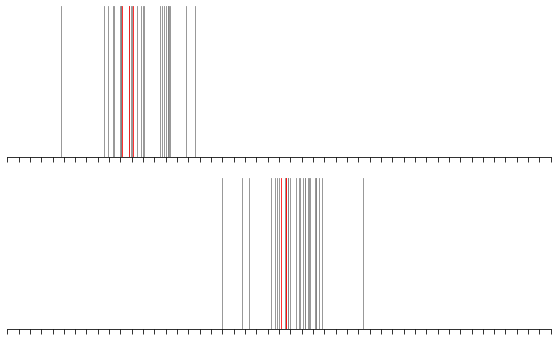

In [24]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
pd.options.mode.chained_assignment = None  # default='warn'

# Read data
df = pd.read_csv('./data/Figure3F_left_data.csv')  
demographics = pd.read_csv('./data/Figure3F_demographics.csv')  

# Flip hemispheres for specific subjects
flip_subjects = ['MA10', 'MA22', 'MA24', 'MA27']
df.loc[df['subj'].isin(flip_subjects), 'hemi'] = df.loc[df['subj'].isin(flip_subjects), 'hemi'].apply(lambda x: 'rh' if x == 'lh' else 'lh')

# Filter data
amp_df = df[df['subj'].str.contains('MA|AA', case=False, na=False)]

# Function to determine side for amputees
def determine_side(row, missing_side=None):
    if missing_side == 0:  # Missing left
        if row['hemi'] == 'lh':
            if row['cope'] == 'lefthand':
                return 'ipsi_ndom'
            elif row['cope'] == 'righthand':
                return 'contra_doi'
            elif row['cope'] == 'lips':
                return 'doi'
        elif row['hemi'] == 'rh':
            if row['cope'] == 'lefthand':
                return 'contra_ndom'
            elif row['cope'] == 'righthand':
                return 'ipsi_doi'
            elif row['cope'] == 'lips':
                return 'ndom'
    elif missing_side == 1:  # Missing right
        if row['hemi'] == 'lh':
            if row['cope'] == 'lefthand':
                return 'ipsi_doi'
            elif row['cope'] == 'righthand':
                return 'contra_ndom'
            elif row['cope'] == 'lips':
                return 'ndom'
        elif row['hemi'] == 'rh':
            if row['cope'] == 'lefthand':
                return 'contra_doi'
            elif row['cope'] == 'righthand':
                return 'ipsi_ndom'
            elif row['cope'] == 'lips':
                return 'doi'

# Add side column to amp_df
amp_df = amp_df.copy()  # Ensure we're not modifying the original DataFrame

def get_missing_side(subj):
    match = demographics.loc[demographics['Subj Code'].str.lower() == subj.lower(), 'Missing Side']
    return match.values[0] if not match.empty else None

amp_df.loc[:, 'side'] = amp_df.apply(lambda row: determine_side(row, get_missing_side(row['subj'])), axis=1)

# Function to calculate CoG, including only bands up to 35
def calculate_cog(dataframe):
    dataframe = dataframe[dataframe['band'] <= 35]  # Include only bands up to 35
    dataframe['band_new'] = dataframe['band'] + 1
    dataframe['fslmeants_norm'] = dataframe['fslmeants'].clip(lower=0)
    dataframe['fslmeants_weighted'] = dataframe['fslmeants_norm'] * dataframe['band_new']
    cog = dataframe['fslmeants_weighted'].sum() / dataframe['fslmeants_norm'].sum()
    return cog if not np.isnan(cog) else 0

# Extract ndom lips and contra_ndom hand activities
ndom_lips_df = amp_df[(amp_df['side'] == 'ndom') & (amp_df['cope'] == 'lips')]
contra_ndom_hand_df = amp_df[(amp_df['side'] == 'contra_ndom') & (amp_df['cope'].isin(['lefthand', 'righthand']))]

# Compute CoG for each subject
subjects = amp_df['subj'].unique()
cog_results = []

for subj in subjects:
    subj_ndom_lips_df = ndom_lips_df[ndom_lips_df['subj'] == subj]
    subj_contra_ndom_hand_df = contra_ndom_hand_df[contra_ndom_hand_df['subj'] == subj]
    
    if not subj_ndom_lips_df.empty:
        cog_ndom_lips = calculate_cog(subj_ndom_lips_df)
    else:
        cog_ndom_lips = np.nan

    if not subj_contra_ndom_hand_df.empty:
        cog_contra_ndom_hand = calculate_cog(subj_contra_ndom_hand_df)
    else:
        cog_contra_ndom_hand = np.nan

    cog_results.append({
        'subj': subj,
        'cope': 'lips',
        'cog': cog_ndom_lips,
        'group': 0
    })
    cog_results.append({
        'subj': subj,
        'cope': 'hand',
        'cog': cog_contra_ndom_hand,
        'group': 0
    })

additional_df = pd.read_csv('./data/Figure2A_data.csv')

aa_subjects = ['sub-aa02', 'sub-aa06','sub-aa03']
for subj in aa_subjects:
    for cope, hemi in [('lips', 'lh'), ('hand', 'rh')]:
        if cope == 'lips' and subj == 'sub-aa06':
            relevant_cope = 11
            hemi = 'rh'
            session = 'post3'
        elif cope == 'hand' and subj == 'sub-aa06':
            relevant_cope = 14
            hemi = 'rh'
            session = 'post3'
        elif cope == 'hand' and subj == 'sub-aa02':
            relevant_cope = 15
            hemi = 'lh'
            session = 'post3'
        elif cope == 'hand' and subj == 'sub-aa03':
            relevant_cope = 14
            hemi = 'rh'
            session = 'post2'
        elif cope == 'lips' and subj == 'sub-aa03':
            relevant_cope = 11
            hemi = 'rh'
            session = 'post2'
        else:
            relevant_cope = 11
            session = 'post3'  # Default to post3 if no specific condition

        # Filter the dataframe based on subject, cope, hemisphere, and session
        subj_df = additional_df[
            (additional_df['subj'] == subj) &
            (additional_df['cope'] == relevant_cope) &
            (additional_df['hemi'] == hemi) &
            (additional_df['session'] == session)
        ]

        if not subj_df.empty:
            cog_value = calculate_cog(subj_df)
        else:
            cog_value = np.nan

        cog_results.append({
            'subj': subj,
            'cope': cope,
            'cog': cog_value,
            'group': 1 if subj == 'sub-aa02' else (2 if subj == 'sub-aa03' else 3)
        })

# Create final dataframe
cog_df = pd.DataFrame(cog_results)

# Plotting
fig, axes = plt.subplots(2, 1, figsize=(8, 5), sharex=True)
plt.style.use("https://raw.githubusercontent.com/NeuromatchAcademy/course-content/master/nma.mplstyle")

# Plot CoG for lips
for _, row in cog_df[cog_df['cope'] == 'lips'].iterrows():
    color = 'red' if row['group'] in [1, 2,3] else 'grey'
    axes[0].axvline(x=row['cog'], color=color, linewidth=.8)

# Plot CoG for hand
for _, row in cog_df[cog_df['cope'] == 'hand'].iterrows():
    color = 'red' if row['group'] in [1, 2,3] else 'grey'
    axes[1].axvline(x=row['cog'], color=color, linewidth=.8)

# Set plot parameters
axes[0].set_xlim(0, 48)
axes[1].set_xlim(0, 48)
axes[0].set_xticks(range(49))
axes[1].set_xticks(range(49))
axes[0].set_xticklabels([''] * 49)
axes[1].set_xticklabels([''] * 49)
#axes[0].set_title('Lips CoG')
#axes[1].set_title('Hand CoG')
axes[0].set_ylabel('Subjects')
axes[1].set_ylabel('Subjects')
#axes[0].get_yaxis().set_visible(False)
#axes[1].get_yaxis().set_visible(False)
axes[0].yaxis.set_visible(False)
axes[1].yaxis.set_visible(False)
# Remove y-axis spines
axes[0].spines['left'].set_visible(False)
axes[1].spines['left'].set_visible(False)

plt.savefig('./figures/Figure3F_middle.png', dpi=300, bbox_inches="tight")

### Figure 3F - right

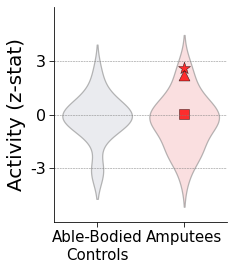

In [23]:

# Load the dataframes
lips_df = pd.read_csv('./data/Figure3F_right_data_lips_cross-sectional.csv')
amp_only_df = pd.read_csv('./data/Figure3F_right_data_lips.csv')
demographics = pd.read_csv('./data/Figure3F_demographics.csv')  

# Extract data for sub-aa02 and sub-aa06 from amp_only_df
aa02_df = amp_only_df[(amp_only_df['subj'] == 'sub-aa02') & (amp_only_df['hemi'] == 'lh') & (amp_only_df['sess'] == 'post3')]
aa06_df = amp_only_df[(amp_only_df['subj'] == 'sub-aa06') & (amp_only_df['hemi'] == 'rh') & (amp_only_df['sess'] == 'post3')]
aa03_df = amp_only_df[(amp_only_df['subj'] == 'sub-aa03') & (amp_only_df['hemi'] == 'rh') & (amp_only_df['sess'] == 'post2')]
# Combine aa02 and aa06 data
aa_combined_d = pd.concat([aa02_df, aa06_df])
aa_combined_df = pd.concat([aa_combined_d, aa03_df])

aa_combined_df['group'] = aa_combined_df['subj'].apply(
    lambda x: 1 if x == 'sub-aa02' else (2 if x == 'sub-aa03' else (3 if x == 'sub-aa06' else None))
)

aa_combined_df['category'] = 'Amputees'
# Separate lips_df into amps_df and ctrls_df
amps_df = lips_df[lips_df['subj'].str.contains('MA|sub-aa', case=False, na=False)]
ctrls_df = lips_df[lips_df['subj'].str.contains('sub-co|MC', case=False, na=False)]
ctrls_df = ctrls_df[(ctrls_df['cope'] == 'lips') & (ctrls_df['hemi'] == 'rh')]

# Add category column to ctrls_df and amps_df
ctrls_df['group'] = 0
amps_df['group'] = 1

# Function to determine side for amputees
def determine_side(row, missing_side=None):
    if missing_side == 0:  # Missing left
        if row['hemi'] == 'lh' and row['cope'] == 'lips':
            return 'ndom'
    elif missing_side == 1:  # Missing right
        if row['hemi'] == 'rh' and row['cope'] == 'lips':
            return 'ndom'
    return None

# Add side column to amps_df
def get_missing_side(subj):
    match = demographics.loc[demographics['Subj Code'].str.lower() == subj.lower(), 'Missing Side']
    return match.values[0] if not match.empty else None

amps_df['side'] = amps_df.apply(lambda row: determine_side(row, get_missing_side(row['subj'])), axis=1)

# Filter amps_df to include only 'lips' activity in the missing hemisphere
amps_df = amps_df[amps_df['side'] == 'ndom']

# Combine all data
combined_df = pd.concat([ctrls_df, amps_df, aa_combined_df])
all_df = pd.concat([ctrls_df, amps_df])

# Plotting
plt.style.use("https://raw.githubusercontent.com/NeuromatchAcademy/course-content/master/nma.mplstyle")

fig, ax = plt.subplots(figsize=(3.5, 4))

colors = ['#DBDFE6','red']

# Violin plot for controls
sns.violinplot(x='group', y='fslmeants', data=all_df, palette=['#DBDFE6', '#FFC2C5'], alpha=0.6, ax=ax, inner=None)

# Group 1 (sub-aa02)
scatter_x_1 = np.full(len(aa02_df), 1)  # Set x position for plotting
ax.scatter(scatter_x_1, aa02_df['fslmeants'], color='red', alpha=0.8, edgecolor='black', linewidth=0.5, s=100, marker='s')

# Group 2 (sub-aa06)
scatter_x_2 = np.full(len(aa06_df), 1)  # Set x position for plotting
ax.scatter(scatter_x_2, aa06_df['fslmeants'], color='red', alpha=0.8, edgecolor='black', linewidth=0.5, s=120, marker='^')

# Group 2 (sub-aa06)
scatter_x_3 = np.full(len(aa03_df), 1)  # Set x position for plotting
ax.scatter(scatter_x_3, aa03_df['fslmeants'], color='red', alpha=0.8, edgecolor='black', linewidth=0.5, s=160, marker='*')

# Set up the x-axis
ax.set_xticks([0, 1])
ax.set_xticklabels(['Able-Bodied\nControls', 'Amputees'], fontsize=15)
#ax.set_xlim(-0.5, 1.5)
ax.set_ylim(-6, 6)

# Label the y-axis
ax.set_ylabel('Activity (z-stat)', fontsize=20)

# Horizontal dashed lines at specified y-values
y_values = [-3, 0, 3]
for y_value in y_values:
    ax.axhline(y=y_value, color='gray', linestyle='--', linewidth=0.5)

# Set y-ticks to only show the specified y-values
ax.set_yticks(y_values)
ax.set_yticklabels([str(val) for val in y_values], fontsize=16)

# Remove the top and right spines
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
plt.xlabel('')
plt.tight_layout()
plt.savefig('./figures/Figure3F_right.png', dpi=600)